# Importing Packages
First, we start by importing some packages like `numpy`, `matplotlib` and also `torch`.

In [1]:
import torchvision
from torchvision import transforms
import torch
import numpy as np
import matplotlib.pyplot as plt
from torch import nn

# Chossing a device 
If there is a cuda available, we are going to train and use our model on gpu

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

# Generator Implementation
Here we define the Generator network of our cGAN. This netwrks gets the random noise and the desired label. It concatenates these inputs and reshape the result. Later, using deconvolutional layers and batch normalization, it turns the vector into a feature map of size 28$\times$28. The activation functions used in this network are *leaky relu* and *tanh*.


In [3]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.embedding = nn.Embedding(10, 64)
        self.fc_noise = nn.Linear(100, 8 * 8 * 255)

        self.deconv1 = nn.ConvTranspose2d(in_channels=256, 
                                          out_channels=128,
                                          kernel_size=5, stride=2)
        
        self.deconv2 = nn.ConvTranspose2d(in_channels=128, 
                                          out_channels=64,
                                          kernel_size=7)
        
        self.deconv3 = nn.ConvTranspose2d(in_channels=64, 
                                          out_channels=1,
                                          kernel_size=4)
        self.norm1 = nn.BatchNorm2d(128)
        self.norm2 = nn.BatchNorm2d(64)

        self.relu = nn.ReLU()
        self.tanh = nn.Tanh()

    def forward(self, noise, class_labels):
        class_labels = self.embedding(class_labels)
        class_labels = class_labels.reshape(class_labels.shape[0], 1, 8, 8)
        noise = self.relu(self.fc_noise(noise))
        noise = noise.reshape(noise.shape[0], 255, 8, 8)
        gen_input = torch.cat((noise, class_labels), dim=1)

        x = self.relu(self.deconv1(gen_input))
        x = self.norm1(x)
        x = self.relu(self.deconv2(x))
        x = self.norm2(x)
        x = self.tanh(self.deconv3(x))
        return x

# Discriminator Implementation
Here we define the Discriminator network of our cGAN. This netwrks gets the image and the desired label. It first reshapes the label vector an then concatenates these inputs. Later, using convolutional layers and batch normalization, it turns the initial feature map of size 2$\times$28$\times$28 into a real number which is between 0 and 1. This number actually represents the probability that the input image was a real one. The activation functions used in this network are *relu* and *sigmoid*.


In [4]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.embedding = nn.Embedding(10, 64)
        self.fc_labels = nn.Linear(64, 784)
        self.conv1 = nn.Conv2d(in_channels=2, 
                               out_channels=64,
                               kernel_size=3, stride=2)
        self.conv2 = nn.Conv2d(in_channels=64, 
                               out_channels=128, 
                               kernel_size=3, stride=2)
        
        self.conv3 = nn.Conv2d(in_channels=128, 
                               out_channels=256, 
                               kernel_size=3, stride=2)
        self.fc_outer = nn.Linear(2*2*256, 1)
        self.norm1 = nn.BatchNorm2d(64)
        self.norm2 = nn.BatchNorm2d(128)
        self.norm3 = nn.BatchNorm2d(256)

        self.leaky_relu = nn.LeakyReLU(0.2, inplace=True)
        self.sigmoid = nn.Sigmoid()


    def forward(self, images, class_labels):
        class_labels = self.embedding(class_labels)
        class_labels = self.fc_labels(class_labels)
        class_labels = class_labels.reshape(class_labels.shape[0], 1, 28, 28)
        disc_input = torch.cat((images, class_labels), dim=1)

        x = self.leaky_relu(self.conv1(disc_input))
        x = self.norm1(x)
        x = self.leaky_relu(self.conv2(x))
        x = self.norm2(x)
        x = self.leaky_relu(self.conv3(x))
        x = self.norm3(x)

        x = torch.flatten(x, start_dim=1)
        x = self.sigmoid(self.fc_outer(x))

        return x

# Train and Analyze cGAN Model
In this class, we train the both aforementione models, the generator and the discriminator. We do the training using two optimizers, namely `Adam` and `RMSProp`. 

Later in this class, in the function `show_samples`, we visualize 10 samples of each 10 clothing categories created by our generator network.

In [15]:
class Model():
    def __init__(self):
        self.trainloader = self.fetch_data()
        self.discriminator = Discriminator().to(device)
        self.generator = Generator().to(device)
    
    def train(self, criterion=nn.BCELoss(), optimizer=torch.optim.Adam, epochs=15):
        D_optimizer = optimizer(self.discriminator.parameters())
        G_optimizer = optimizer(self.generator.parameters())
        disc_losses = []
        gen_losses = []
        for epoch in range(epochs):
            disc_running_loss = 0
            gen_running_loss = 0
            for real_images, real_labels in self.trainloader:
                real_images = real_images.to(device)
                real_labels = real_labels.to(device)
                y_binary_real = torch.ones((real_labels.shape[0], 1), device=device)

                #### Starting to train Discriminator ####
                D_optimizer.zero_grad()
                disc_output = self.discriminator(real_images, real_labels)
                loss1 = criterion(disc_output, y_binary_real)
                loss1.backward()

                noise = torch.randn(128, 100, device=device)
                fake_labels = torch.randint(10, (128, 1), device=device)
                fake_images = self.generator(noise, fake_labels)
                y_binary_fake = torch.zeros(fake_labels.shape[0], 1, device=device)
                
                disc_output = self.discriminator(fake_images.detach(), fake_labels.detach())
                loss2 = criterion(disc_output, y_binary_fake)
                loss2.backward()
                disc_running_loss += loss2.item() + loss1.item()

                D_optimizer.step()

                #### Starting to train Generator ####
                G_optimizer.zero_grad()
                y_gan = torch.ones(fake_labels.shape[0], 1, device=device)
                disc_output = self.discriminator(fake_images, fake_labels)
                loss3 = criterion(disc_output, y_gan)
                loss3.backward()
                G_optimizer.step()
                gen_running_loss += loss3.item()
            
            disc_losses.append(disc_running_loss/len(self.trainloader))
            gen_losses.append(gen_running_loss/len(self.trainloader))
            print("for eopch {}, discriminator train loss is {:.8f}".format(epoch+1, disc_losses[-1]))
            print("for eopch {}, generator train loss is {:.8f}".format(epoch+1, gen_losses[-1]))
            print()
        
        plt.figure(figsize=(10, 8))
        plt.plot(range(len(disc_losses)), disc_losses, label="discriminator loss")
        plt.plot(range(len(gen_losses)), gen_losses, label="generator loss")
        plt.legend()
        
        self.show_samples()

    def show_samples(self):
        fig, axs = plt.subplots(10, 10, figsize=(10, 10))
        for i in range(10):
            for j in range(10):
                noise = torch.randn(1, 100, device=device)
                label = torch.LongTensor([j]).to(device)
                image = self.generator(noise, label)
                axs[i, j].imshow(image.cpu().detach().reshape(28, 28), cmap="gray")
                axs[i, j].set_axis_off()  
        

    def fetch_data(self):
        transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5), (0.5))])
        
        trainset = torchvision.datasets.FashionMNIST(root = "./data",
                                                     train=True, download=True,
                                                     transform = transform)
        
        trainloader = torch.utils.data.DataLoader(trainset,
                                                  batch_size=128, shuffle=True)
        return trainloader
        

for eopch 1, discriminator train loss is 2.51098684
for eopch 1, generator train loss is 4.10899388

for eopch 2, discriminator train loss is 0.76026181
for eopch 2, generator train loss is 3.49616404

for eopch 3, discriminator train loss is 1.10043815
for eopch 3, generator train loss is 1.97397231

for eopch 4, discriminator train loss is 1.00330489
for eopch 4, generator train loss is 2.32753298

for eopch 5, discriminator train loss is 0.85565764
for eopch 5, generator train loss is 2.96823990

for eopch 6, discriminator train loss is 0.80463281
for eopch 6, generator train loss is 3.29452114

for eopch 7, discriminator train loss is 0.77335570
for eopch 7, generator train loss is 3.47131120

for eopch 8, discriminator train loss is 0.76006166
for eopch 8, generator train loss is 3.71848171

for eopch 9, discriminator train loss is 0.71417446
for eopch 9, generator train loss is 3.92694342

for eopch 10, discriminator train loss is 0.69450845
for eopch 10, generator train loss is 

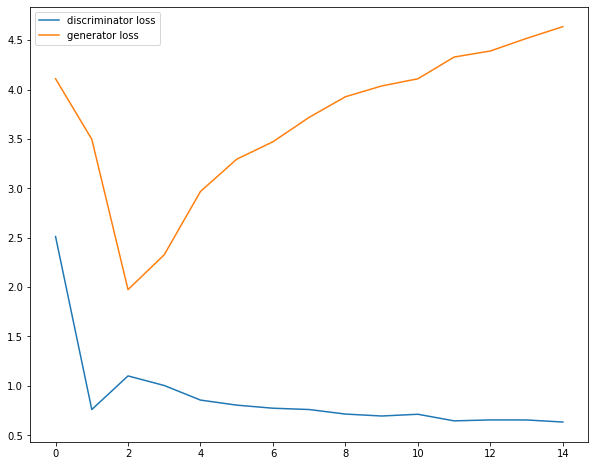

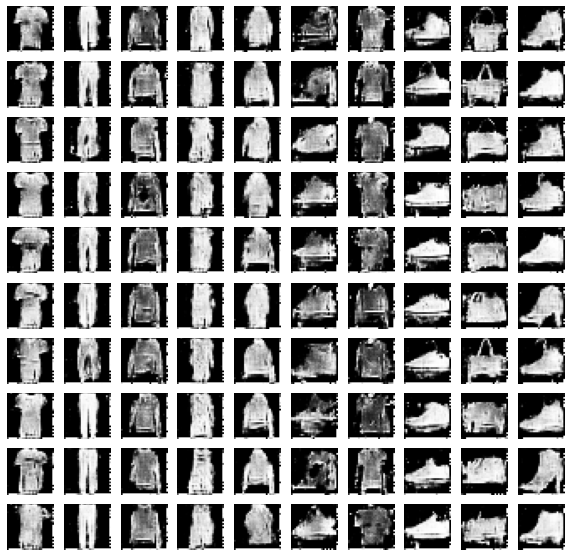

In [9]:
model = Model()
model.train(criterion=nn.BCELoss(), optimizer=torch.optim.RMSprop)

for eopch 1, discriminator train loss is 0.19746367
for eopch 1, generator train loss is 6.42481704

for eopch 2, discriminator train loss is 0.18580326
for eopch 2, generator train loss is 6.39156369

for eopch 3, discriminator train loss is 0.24880647
for eopch 3, generator train loss is 5.74560432

for eopch 4, discriminator train loss is 0.26616285
for eopch 4, generator train loss is 5.32146199

for eopch 5, discriminator train loss is 0.15537652
for eopch 5, generator train loss is 5.29650726

for eopch 6, discriminator train loss is 0.14670077
for eopch 6, generator train loss is 5.90804304

for eopch 7, discriminator train loss is 0.08430495
for eopch 7, generator train loss is 6.02534935

for eopch 8, discriminator train loss is 0.11649489
for eopch 8, generator train loss is 6.27664676

for eopch 9, discriminator train loss is 0.12751420
for eopch 9, generator train loss is 7.10910565

for eopch 10, discriminator train loss is 0.07934364
for eopch 10, generator train loss is 

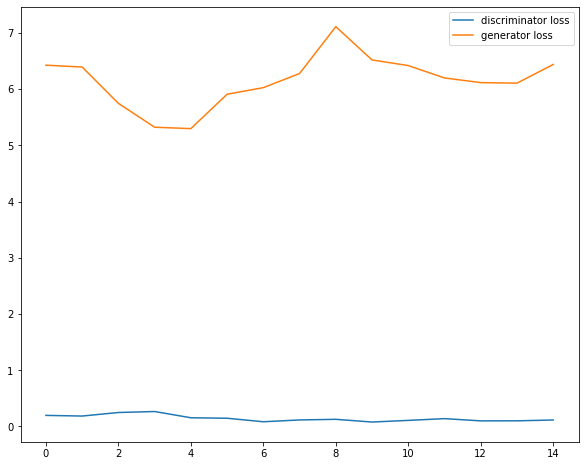

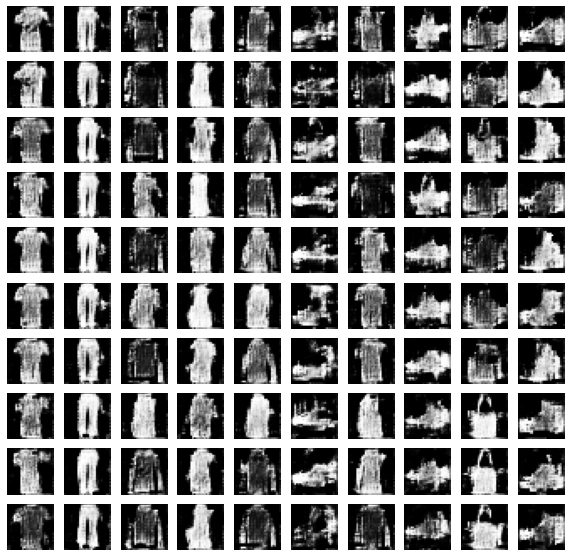

In [10]:
model = Model()
model.train(criterion=nn.BCELoss(), optimizer=torch.optim.Adam)